In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
!unzip -q database6.zip
!ls

database6  database6.zip  sample_data


In [ ]:
!ls database6/training

NO_SRB	SRB


In [ ]:
image_size = (180, 180)
batch_size = 32

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "database6/training",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1102 files belonging to 2 classes.
Using 882 files for training.
Using 220 files for validation.


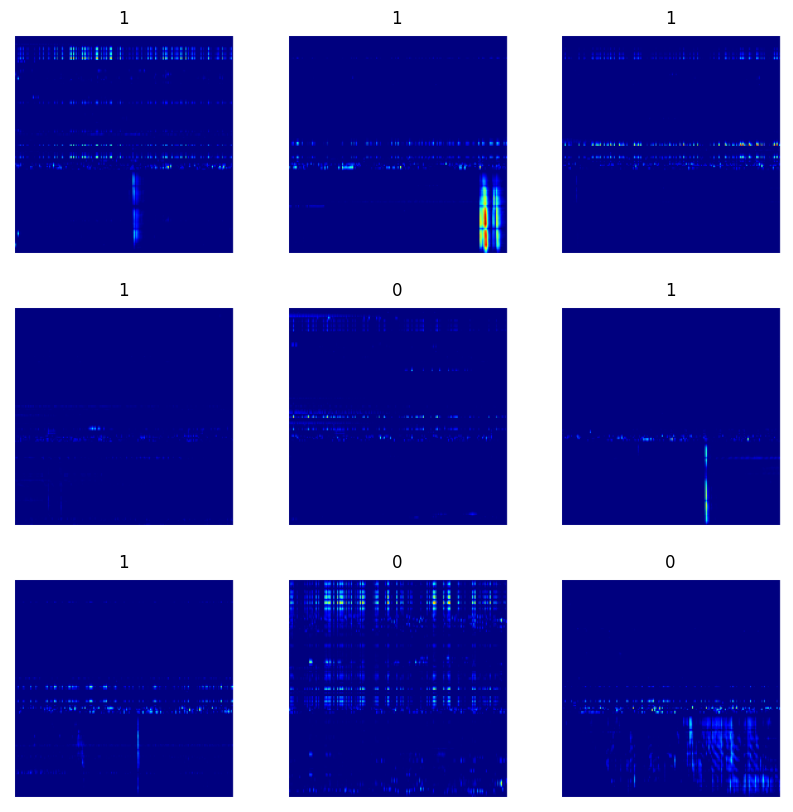

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
    ]
)

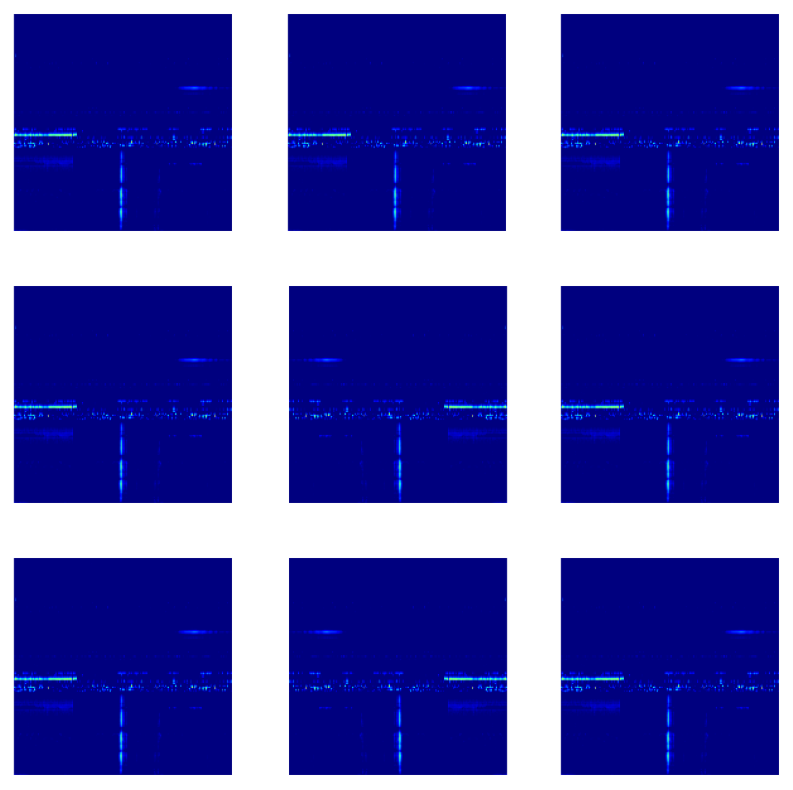

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
inputs = keras.Input(shape=image_size)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

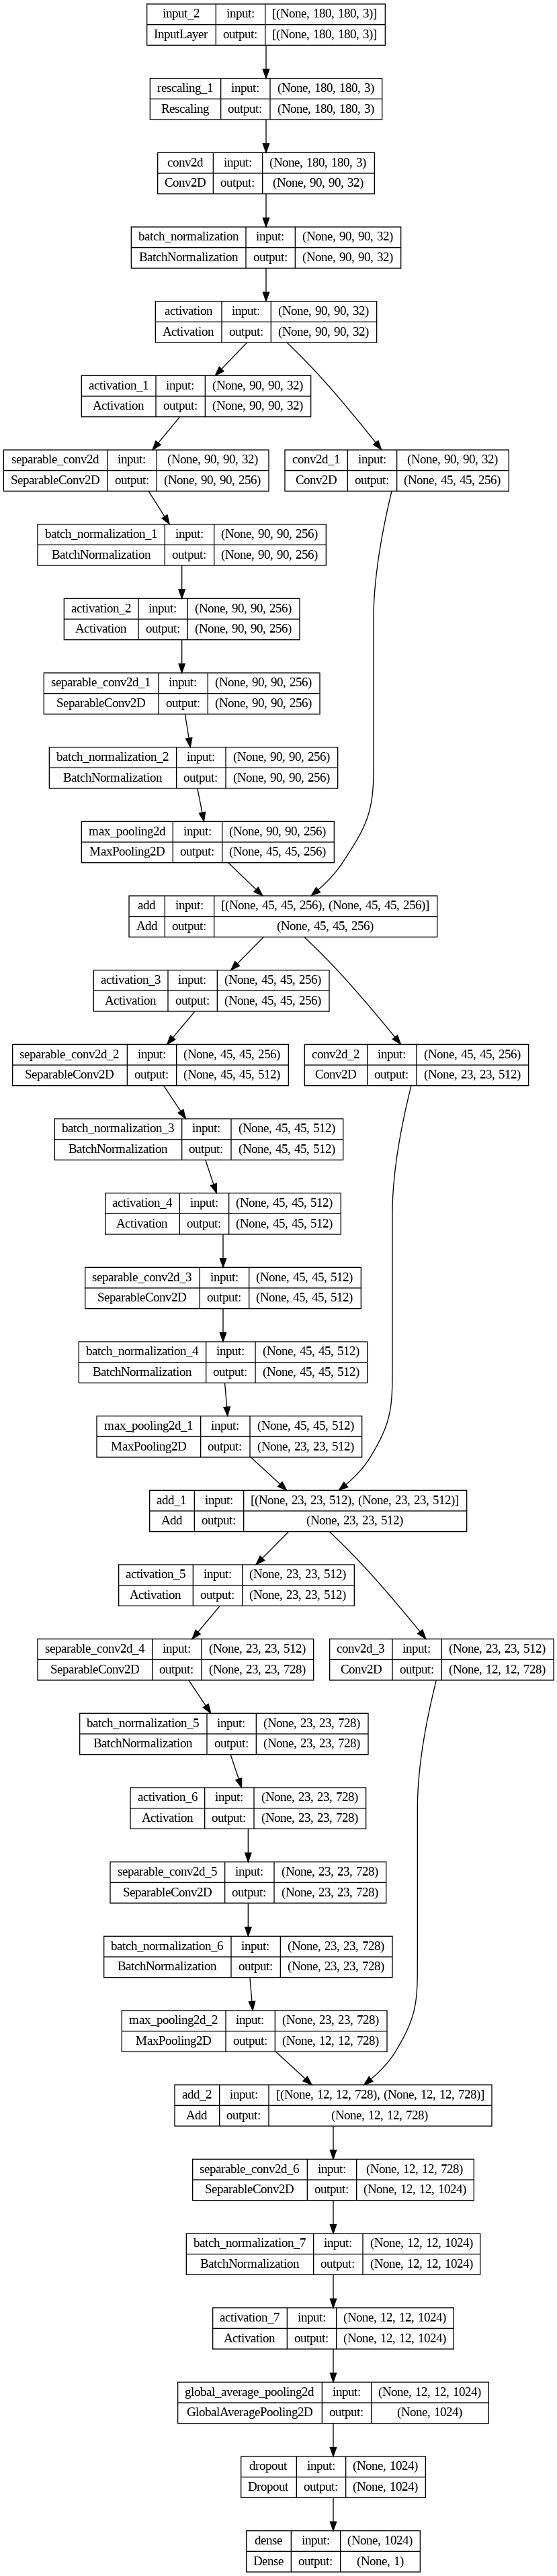

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
hist=model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/50
28/28 [==============================] - 35s 447ms/step - loss: 0.7362 - accuracy: 0.5578 - val_loss: 0.6941 - val_accuracy: 0.4818
Epoch 2/50
28/28 [==============================] - 11s 362ms/step - loss: 0.6727 - accuracy: 0.5986 - val_loss: 0.6968 - val_accuracy: 0.5182
Epoch 3/50
28/28 [==============================] - 10s 300ms/step - loss: 0.6130 - accuracy: 0.6610 - val_loss: 0.7273 - val_accuracy: 0.5182
Epoch 4/50
28/28 [==============================] - 9s 305ms/step - loss: 0.4530 - accuracy: 0.8197 - val_loss: 0.7957 - val_accuracy: 0.5182
Epoch 5/50
28/28 [==============================] - 10s 312ms/step - loss: 0.3742 - accuracy: 0.8492 - val_loss: 0.8446 - val_accuracy: 0.5182
Epoch 6/50
28/28 [==============================] - 10s 328ms/step - loss: 0.3172 - accuracy: 0.8832 - val_loss: 0.9362 - val_accuracy: 0.5182
Epoch 7/50
28/28 [==============================] - 10s 342ms/step - loss: 0.2943 - accuracy: 0.8912 - val_loss: 0.9739 - val_accuracy: 0.5182


In [ ]:
img = keras.utils.load_img(
    "database6/test/SRB/HUMAIN_20220924_084500_59.png", target_size=image_size
)
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% NO SRB and {100 * score:.2f}% SRB.")

1/1 [==============================] - 0s 30ms/step
This image is 0.17% NO SRB and 99.83% SRB.


In [ ]:
img = keras.utils.load_img(
    "database6/test/NO_SRB/HUMAIN_20220601_114500_59.png", target_size=image_size
)
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% NO SRB and {100 * score:.2f}% SRB.")

1/1 [==============================] - 0s 21ms/step
This image is 0.14% NO SRB and 99.86% SRB.


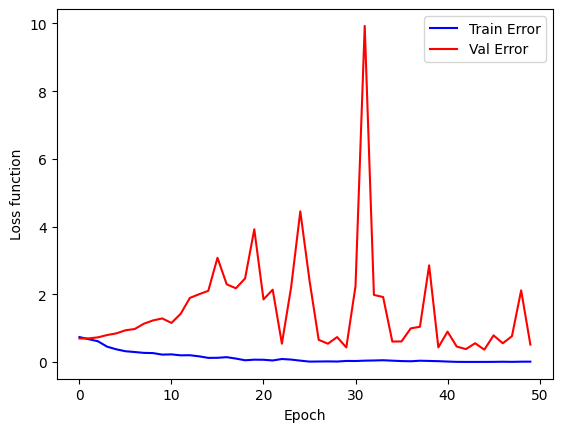

In [ ]:
import matplotlib.pyplot as plt

def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss function')
    plt.plot(hist.epoch, hist.history['loss'],'b', label='Train Error')
    plt.plot(hist.epoch, hist.history['val_loss'],'r', label = 'Val Error')
    plt.legend()

plot_history()

In [ ]:
# SRB
import os
srb_acertados=0
for line in os.listdir("database6/test/SRB"):
  if line[-3:]=="png":
    img = keras.utils.load_img(
        "database6/test/SRB/"+line, target_size=image_size
    )
    img_array = keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array)
    score = float(predictions[0])

    no_srb= 1 - score;
    srb= score;

    if srb>no_srb:
      srb_acertados+=1

print(srb_acertados)
srb_falsos=137-srb_acertados
p_acertados=float(srb_acertados/137)
print(f"La precision de aciertos es del {100*p_acertados:.2f}%")



1/1 [==============================] - 0s 19ms/step
131
La precision de aciertos es del 95.62%


In [ ]:
# NO SRB
import os
nsrb_acertados=0
for line in os.listdir("database6/test/NO_SRB"):
  if line[-3:]=="png":
    img = keras.utils.load_img(
        "database6/test/NO_SRB/"+line, target_size=image_size
    )
    img_array = keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array)
    score = float(predictions[0])

    no_srb= 1 - score;
    srb= score;

    if srb<no_srb:
      nsrb_acertados+=1

print(nsrb_acertados)
nsrb_falsos=137-nsrb_acertados
p_acertados=float(nsrb_acertados/137)
print(f"La precision de aciertos es del {100*p_acertados:.2f}%")

1/1 [==============================] - 0s 22ms/step
112
La precision de aciertos es del 81.75%


In [ ]:
# Matriz de confusión

import pandas as pd
import numpy as np
data = np.array([[srb_acertados,nsrb_falsos],
                 [srb_falsos,nsrb_acertados]])
df = pd.DataFrame(data, index=['SRB','NO SRB'],columns=['Estimado SRB', 'Estimado NO SRB'])

print(df)

print(f"\nVerdaderos positivos: {100*float(srb_acertados/137):.2f}%")
print(f"Falsos positivos: {100*float(srb_falsos/137):.2f}%")
print(f"Verdaderos negativos: {100*float(nsrb_acertados/137):.2f}%")
print(f"Falsos negativos: {100*float(nsrb_falsos/137):.2f}%")
print(f"\nPrecisión del modelo: {100*float((srb_acertados+nsrb_acertados)/274):.2f}%")

        Estimado SRB  Estimado NO SRB
SRB              131               25
NO SRB             6              112

Verdaderos positivos: 95.62%
Falsos positivos: 4.38%
Verdaderos negativos: 81.75%
Falsos negativos: 18.25%

Precisión del modelo: 88.69%
